In [1]:
import sys
import os
sys.path.insert(2, '/global/project/projectdirs/lux/Tools/root_pdsf/root/lib')
#sys.path.insert(2,'/global/project/projectdirs/lux/Tools/anaconda/lib/python2.7/site-packages/root_numpy-4.3.0-py2.7-linux-x86_64.egg')
from ROOT import TCanvas, TPad, TFile, TPaveText, TChain, TCut, TF1, TH1F, TH2F, TLine,TLegend
from ROOT import gBenchmark, gStyle, gROOT
#import root_numpy

In [2]:
import rootnotes_nersc
from rootnotes_nersc import rtshow, clearCanvas
from numpy import *
import scipy
import pylab
import matplotlib.pyplot as plt # plotting libraries from matlab
from scipy.stats import multivariate_normal
from dateutil import parser
from matplotlib import pyplot as plt
import matplotlib.dates as md
import scipy.io as sio

In [3]:
%pylab inline  
#always do this for plotting...  don't ask why
#now set the size of figures to display in window
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data')
import aLib

In [5]:
g1=0.1167
g2=12.05

g1DD=g1*0.982
g2DD=g2*0.954

<h1> Fit exponential decay </h1>

In [6]:
from scipy.optimize import curve_fit
from __future__ import division

def func(x, a, c):
    return a*np.exp(-x/c)

def funsin(x, a, b, c):
    return c+a*np.cos(2*pi*(x-b)/365)

<h1> 2D Normal fitting  </h1>

In [7]:
import scipy.optimize as opt
import numpy as np

def twoD_Gaussian((x, y), amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

<h1> Load in all the LUX Run03 WIMP Search Data </h1>

In [8]:
chain6 = TChain('golden')
chain6.Add('/project/projectdirs/lux/data/golden/Golden_PostDD_Run03.root')

chain5 = TChain('golden')
chain5.Add('/project/projectdirs/lux/data/golden/Golden_CH3T_*.root')

chain4 = TChain('golden')
chain4.Add('/project/projectdirs/lux/data/golden/Golden_DD_*.root')

chain3 = TChain('golden')
chain3.Add('/project/projectdirs/lux/data/golden/Golden_Cs137_Aug.root')

chain2 = TChain('golden')
chain2.Add('/project/projectdirs/lux/data/golden/Golden_XeAct/*.root')

chain = TChain('golden')
chain.Add('/project/projectdirs/lux/data/golden/Golden_Run03/Golden_150303_WS*.root')

9

<h1> Define the S1 and S2 cuts to seperate the islands of energy (see later plots) </h1>

In [9]:
Energies=[2.8]
NamesE=["2.8 keV, 5.2 keV X-ray"]
cutsE=array([[2, 3.2],
           [4.0,6.5]])


mean_s2=zeros(len(Energies))
mean_s2_sig=zeros(len(Energies))
mean_s1=zeros(len(Energies))
mean_s1_sig=zeros(len(Energies))

<h1> 2.8 and 5.2 keV lines in the WS data </h1>

<h3> First plot the WS data, with 3 sigma ER band as per the tiritum calibration </h3>

In [10]:
c1 = rootnotes_nersc.default_canvas(name='icanvas7', size=(800, 600))

In [11]:
#95% ER bounds from tritium

au = 3.2  #use 3.10 for 2 sigma bounds #90% 3.007
bu = -0.1158 
    
al = 2.5; # use 2.592 for 2 sigma #90% 2.682
bl =-0.1197;

er_cut_l=TCut('log10(s2area/spikyS1)>{:g}*spikyS1^{:g}'.format(al,bl))
er_cut_u=TCut('log10(s2area/spikyS1)<{:g}*spikyS1^{:g}'.format(au,bu))


fid_vol=TCut('drift>35 && drift<308 && correctedRadius<25')
exclusion_cut=TCut('partner==0 && excluded==0 ')
area_cut=TCut('spikyS1>0 && s1area<50 && spikyS1<50 && s2area_raw>150 && s2area>100 && s2area<10**5')
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')
combined_cut=TCut(fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle() + '&&' + er_cut_l.GetTitle() + '&&' + er_cut_u.GetTitle() + '&&' + exclusion_cut.GetTitle() );

density_plt_hst=TH2F('density_plt_hst','Run03 WS;spikyS1;log10(s2area/s1area)',50,0,50,50,1,3)

#chain2.SetMarkerStyle(6)
#chain2.SetMarkerSize(10)
n=chain.Draw('log10(s2area/spikyS1):spikyS1>>density_plt_hst',combined_cut,'colz') # WS is chain, chain2 is XeAct, chain3 is Cs137, 4 is DD

fun1 = TF1( 'fun1', '{:g}*x^{:g}'.format(al,bl), 0, 50)
fun2 = TF1( 'fun1', '{:g}*x^{:g}'.format(au,bu), 0, 50)
fun1.Draw('Same')
fun2.Draw('Same')

rtshow(c1)

<h1> Make a cut around 24 hours of each Kr83 calibration </h1>

In [10]:
Kr_files=array([['lux10_20130422T2031'],
       ['lux10_20130424T1406'],
       ['lux10_20130424T1740'],
       ['lux10_20130425T1047'],
       ['lux10_20130426T0951'],
       ['lux10_20130426T1019'],
       ['lux10_20130429T1433'],
       ['lux10_20130429T1447'],
       ['lux10_20130501T1508'],
       ['lux10_20130503T1457'],
       ['lux10_20130506T1328'],
       ['lux10_20130510T1250'],
       ['lux10_20130510T1607'],
       ['lux10_20130510T2008'],
       ['lux10_20130511T0014'],
       ['lux10_20130513T1438'],
       ['lux10_20130517T1508'],
       ['lux10_20130517T1542'],
       ['lux10_20130517T1810'],
       ['lux10_20130520T1444'],
       ['lux10_20130520T1504'],
       ['lux10_20130520T1742'],
       ['lux10_20130520T1758'],
       ['lux10_20130520T1909'],
       ['lux10_20130524T1503'],
       ['lux10_20130524T1537'],
       ['lux10_20130524T1829'],
       ['lux10_20130528T1304'],
       ['lux10_20130528T1546'],
       ['lux10_20130529T1517'],
       ['lux10_20130529T1547'],
       ['lux10_20130529T2003'],
       ['lux10_20130531T1403'],
       ['lux10_20130531T1421'],
       ['lux10_20130604T1421'],
       ['lux10_20130604T1737'],
       ['lux10_20130604T2137'],
       ['lux10_20130604T2334'],
       ['lux10_20130607T1512'],
       ['lux10_20130610T1518'],
       ['lux10_20130614T1623'],
       ['lux10_20130617T1457'],
       ['lux10_20130621T1533'],
       ['lux10_20130626T1028'],
       ['lux10_20130626T1517'],
       ['lux10_20130628T1444'],
       ['lux10_20130701T1451'],
       ['lux10_20130701T1646'],
       ['lux10_20130701T2257'],
       ['lux10_20130705T1530'],
       ['lux10_20130709T1009'],
       ['lux10_20130709T1811'],
       ['lux10_20130712T1427'],
       ['lux10_20130712T2232'],
       ['lux10_20130717T1424'],
       ['lux10_20130717T2212'],
       ['lux10_20130720T1045'],
       ['lux10_20130720T1908'],
       ['lux10_20130723T1452'],
       ['lux10_20130723T2205'],
       ['lux10_20130726T1224'],
       ['lux10_20130726T1431'],
       ['lux10_20130726T1819'],
       ['lux10_20130727T0000'],
       ['lux10_20130729T1004'],
       ['lux10_20130729T1752'],
       ['lux10_20130729T2337'],
       ['lux10_20130807T1035'],
       ['lux10_20130807T1403'],
       ['lux10_20130807T2233'],
       ['lux10_20130812T1530'],
       ['lux10_20130812T1546'],
       ['lux10_20130812T2259'],
       ['lux10_20130813T0652'],
       ['lux10_20130823T0953'],
       ['lux10_20130823T1717'],
       ['lux10_20130823T2119'],
       ['lux10_20130829T1005']
               ])

Kr_file_dates=[]
for ii in range(0,Kr_files.size):
    Kr_file_dates.append(parser.parse(Kr_files[ii,0][6:]))

Kr_file_dates=array(Kr_file_dates)

lux_epoch=md.datestr2num('Jan 1st 2011 at 00:00')
Kr_lux_stamps=(md.date2num(Kr_file_dates)-lux_epoch)*24*3600*10**8

In [11]:
start_delay=1*3600*10**8
end_delay=24*3600*10**8
kr_time_cut_all=TCut('')

for ii in range(0,Kr_lux_stamps.size):
    kr_time_cut=TCut('!(luxstamp>{:.0f} && luxstamp<{:.0f})'.format(Kr_lux_stamps[ii]-start_delay,Kr_lux_stamps[ii]+end_delay))
    if ii==0:
        kr_time_cut_all=TCut(kr_time_cut.GetTitle());
    else:
        kr_time_cut_all=kr_time_cut_all+kr_time_cut
        #kr_time_cut_all=TCut(kr_time_cut_all.GetTitle() +'||'+ kr_time_cut.GetTitle());

<h1> Get livetime info </h1>

In [12]:
#data=sio.loadmat('Run03Golden.mat')
#GoldenDays=data['fuckthis'][:,0][0]
#Golden_Livetime=data['fuckthis'][:,1][0] #livetime in hours
#data=loadtxt('Run03_Golden_Livetime.txt')

GoldenDays,Golden_Livetime =loadtxt('Run03_Golden_Livetime.txt',dtype={'names':('filename_prefix', 'livetime_h'), 'formats':('S19', 'f')},delimiter='    ',usecols=(0, 1),unpack=True)
Golden_Livetime_days=Golden_Livetime/24

GoldenFile_dates=[]
for ii in range(0,GoldenDays.size):
    GoldenFile_dates.append(parser.parse(GoldenDays[ii][6:]))

GoldenFile_dates=array(GoldenFile_dates)

lux_epoch=md.datestr2num('Jan 1st 2011 at 00:00')
Run03Golden_lux_stamps=(md.date2num(GoldenFile_dates)-lux_epoch)*24*3600*10**8
Run03Golden_lux_stamps=uint64(Run03Golden_lux_stamps) #set to uint64 type

#removing Kr livetime. Define a cut to do this
time_diff=-1
kr_livetime_cut=ones(Run03Golden_lux_stamps.size,dtype=bool)
for ii in range(0,Run03Golden_lux_stamps.size):
    for jj in range(0,Kr_lux_stamps.size):
        time_diff=Run03Golden_lux_stamps[ii] - Kr_lux_stamps[jj]
        if aLib.inrange(time_diff,[0,16*3600*10**8]):
            kr_livetime_cut[ii]=0

In [13]:
#Write arrays with LUXSTAMP to file
#savetxt('Run03_Golden_Livetime_withStamps.txt',vstack([GoldenDays.T, Run03Golden_lux_stamps.T, Golden_Livetime.T]).T,fmt=('%s','%s','%s'))

<h1> Argon37? Rate spike cut </h1>

In [14]:
# June 2 = 7629482392360554
#2 bins June 11 = 7708629502443002
#3rd bin to June 20 = 7787776612525449
rate_spike_cut=TCut('(luxstamp>7550335282278107 && luxstamp<7629482392360554) ')

<h1> Now histogram the ER events at low energy (around 3 sigma as defined by tritium) </h1>

In [17]:
#c2.Clear()

In [15]:
c2 = rootnotes_nersc.default_canvas(name='icanvas2', size=(800, 600))

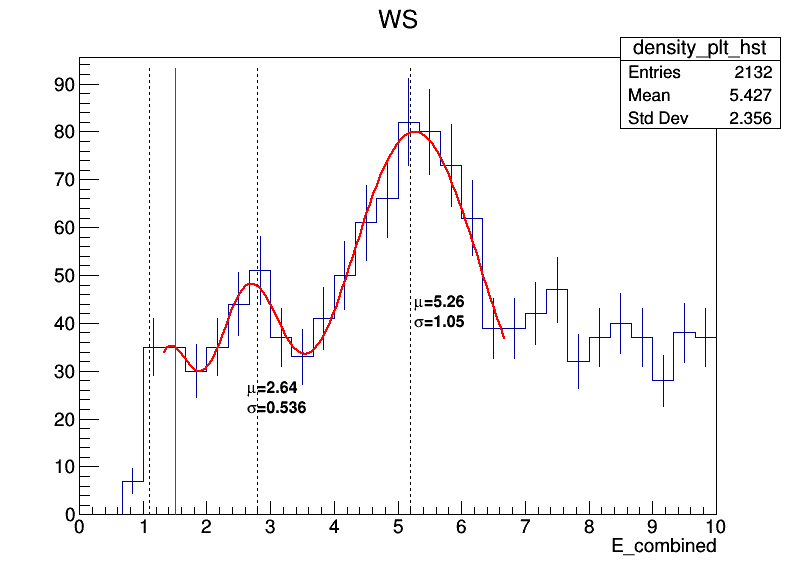

In [16]:
au = 3.2  #use 3.10 for 2 sigma bounds #90% 3.007
bu = -0.1158 
    
al = 2.5; # use 2.592  for 2 sigma #90% 2.682
bl =-0.1197;

er_cut_l=TCut('log10(s2area/spikyS1)>{:g}*spikyS1^{:g}'.format(al,bl))
er_cut_u=TCut('log10(s2area/spikyS1)<{:g}*spikyS1^{:g}'.format(au,bu))

exclusion_cut=TCut('partner==0 && excluded==0 ')
fid_vol=TCut('drift>35 && drift<305 && correctedRadius<22') # && luxstamp/10**15>7.86'#add time cut ... 'luxstamp/10**15 ...&& luxstamp/10**15<8.5
area_cut=TCut('spikyS1>0 && spikyS1<100 && s1area<100 && s1area>0 && s2area_raw>150 && s2area>100 && s2area<10**4') #spikyS1
bad_area_cut=TCut('((goodArea<=630 && badArea < 80) || (goodArea>630 && badArea < 80+0.095*(goodArea-630)))')
ercut= er_cut_l.GetTitle() + '&&' + er_cut_u.GetTitle()
#tb_asym_cut=TCut('tb_asymmetry>=-1')
#energy_cut=TCut('1/73*(spikyS1/{:g}+s2area/{:g})'.format(g1,g2)+'<4 &&1/73*(spikyS1/{:g}+s2area/{:g})'.format(g1,g2)+'>1.5' )
combined_cut=TCut(fid_vol.GetTitle() + '&&'+ area_cut.GetTitle() + '&&' + bad_area_cut.GetTitle() + '&&' + ercut + '&&' + exclusion_cut.GetTitle() );

density_plt_hst=TH1F('density_plt_hst','WS;E_combined',30,0,10)
n=chain.Draw('1/73*(spikyS1/{:g}+s2area/{:g})>>density_plt_hst'.format(g1,g2),combined_cut) # WS is chain2 #  Cs is chain3
density_plt_hst.SetOption("EH")


amps=[]
means=[]
means_err=[]
sigmas=[]
sigmas_err=[]
Texts=[]

density_plt_hst.Fit("gaus","","",cutsE[0,0],cutsE[0,1]);
fitter = TVirtualFitter.GetFitter()
amps.append(density_plt_hst.GetFunction("gaus").GetParameter(0) )
means.append(density_plt_hst.GetFunction("gaus").GetParameter(1) )
means_err.append(sqrt(fitter.GetCovarianceMatrixElement(1,1)))
sigmas.append(density_plt_hst.GetFunction("gaus").GetParameter(2) )
sigmas_err.append(sqrt(fitter.GetCovarianceMatrixElement(2,2)))

density_plt_hst.Fit("gaus","","",cutsE[1,0],cutsE[1,1]);
fitter = TVirtualFitter.GetFitter()
amps.append(density_plt_hst.GetFunction("gaus").GetParameter(0) )
means.append(density_plt_hst.GetFunction("gaus").GetParameter(1) )
means_err.append(sqrt(fitter.GetCovarianceMatrixElement(1,1)))
sigmas.append(density_plt_hst.GetFunction("gaus").GetParameter(2) )
sigmas_err.append(sqrt(fitter.GetCovarianceMatrixElement(2,2)))

amps=array(amps)
means=array(means)
means_err=array(means_err)
sigmas=array(sigmas)
sigmas_err=array(sigmas_err)

#total = TF1("total","gaus(0)+gaus(3)+0*x",cutsE[0,0]-.5,cutsE[1,1]+0.5)
total = TF1("total","gaus(0)+gaus(3)+gaus(6)+1*x",cutsE[0,0]-0.7,cutsE[1,1]+0.2)

total.SetLineColor(2)

par_tot=array([amps[0],means[0],sigmas[0],amps[1],means[1],sigmas[1]])
par_tot=array([amps[0],means[0],sigmas[0],amps[1],means[1],sigmas[1],amps[0]*0.221,1.1,1])


total.SetParameters(par_tot);
density_plt_hst.Fit(total,"R"); #use R+ to keep old fit
par=total.GetParameters();
fitter = TVirtualFitter.GetFitter()

amps=array([par[0],par[3],par[6]])
amps_err=array([sqrt(fitter.GetCovarianceMatrixElement(0,0)),sqrt(fitter.GetCovarianceMatrixElement(3,3)),sqrt(fitter.GetCovarianceMatrixElement(6,6))])
means=array([par[1],par[4],par[7]])
means_err=array([sqrt(fitter.GetCovarianceMatrixElement(1,1)),sqrt(fitter.GetCovarianceMatrixElement(4,4)),sqrt(fitter.GetCovarianceMatrixElement(7,7))])
sigmas=array([par[2],par[5],par[8]])
sigmas_err=array([sqrt(fitter.GetCovarianceMatrixElement(2,2)),sqrt(fitter.GetCovarianceMatrixElement(5,5)),sqrt(fitter.GetCovarianceMatrixElement(8,8))])

            
for ii, mu in enumerate(means[:-1]):
    Texts.append(TLatex(mu,amps[ii]*0.55,'#splitline{{#mu={:1.3g}}}{{#sigma={:1.3g}}}'.format(means[ii],sigmas[ii]) ))
    Texts[ii].SetTextSize(0.03)
    Texts[ii].Draw()


#density_plt_hst.Fit("gaus","+","",cutsE[0,0],cutsE[0,1]);
#density_plt_hst.Fit("gaus","+","",cutsE[1,0],cutsE[1,1]);

aline=[]
Energies=[1.1,2.8,5.2] 

for ii, En in enumerate(Energies):
    aline.append(TLine(En,0,En,amps.max()*1.25))
    aline[ii].SetLineStyle(2)
    aline[ii].SetLineColor(1) #black =1
    aline[ii].Draw()

Thresh=TLine(1.5,0,1.5,amps.max()*1.25)#energy threshold
Thresh.SetLineColor(2)
Thresh.Draw()

gStyle.SetOptFit(0) # superimpose fit results

rtshow(c2)

In [88]:
count=sqrt(2*pi)*par[2]*par[0]

In [89]:
count

14.821638744198051

In [118]:
count_Xe=sqrt(2*pi)*par[5]*par[3]


In [119]:
count_Xe

21.778367278632512

In [18]:
means_err

array([ 0.22953428,  0.09302866,  1.1461343 ])

<h1> Cut in energy and find decay rate of 5.3 keV x-ray </h1>

In [169]:
#c5.Clear()

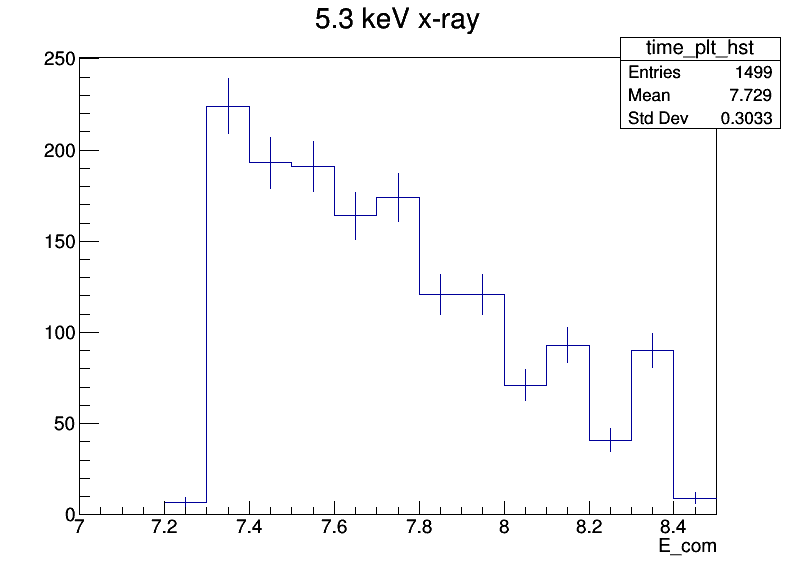

In [28]:
c5 = rootnotes_nersc.default_canvas(name='time_hist')

energy_cut=TCut('1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'>4.3 &&1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'<6.3' )

time_plt_hst=TH1F('time_plt_hst','5.3 keV x-ray;E_com',15,7,8.5)
n=chain.Draw('luxstamp/10**15>>time_plt_hst',combined_cut + energy_cut) # WS is chain2,
time_plt_hst.SetOption("EH")

show(c5)

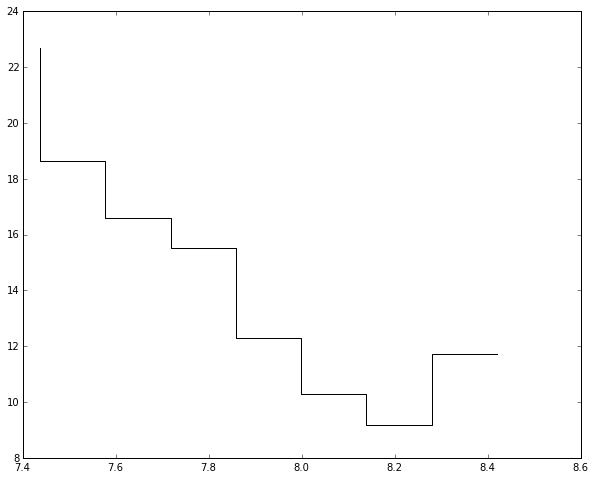

In [29]:
luxstamps = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
luxstamps_hist, xedges = histogram(luxstamps,8) #linspace(7,8.5,10)
bin_center=(xedges[1:]+xedges[:-1])/2

livetime_in_bin=[]
for ii in range(0,luxstamps_hist.size):
    hist_cut=aLib.inrange(Run03Golden_lux_stamps/10**15,(xedges[ii],xedges[ii+1]))
    livetime_in_bin.append(Golden_Livetime_days[hist_cut].sum())

    
livetime_in_bin=array(livetime_in_bin)
plt.plot(xedges[1:],luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')

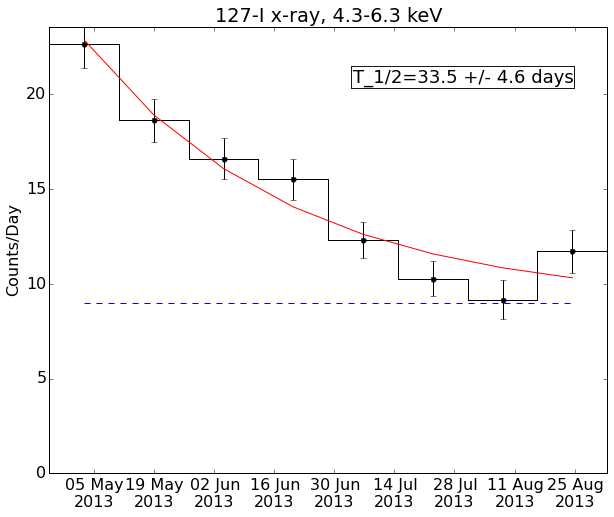

In [30]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=bin_center*10**7/3600/24
luxstamp2day_edge_l=xedges[1:]*10**7/3600/24
luxstamp2day_edge_r=xedges[:-1]*10**7/3600/24

luxdatenum=luxstamp2day+lux_epoch
luxdatenum_edge_l=luxstamp2day_edge_l+lux_epoch
luxdatenum_edge_r=luxstamp2day_edge_r+lux_epoch

###########
fit_start=datestr2num('May 1 2013 at 00:00')
fit_end=datestr2num('Sep 1 2013 at 00:00')
fit_offset=9
fit_range=(luxdatenum>fit_start) & (luxdatenum<fit_end)
###########

popt, pcov = curve_fit(func, (luxdatenum[fit_range]-luxdatenum[0]), (luxstamps_hist[fit_range]/livetime_in_bin[fit_range])-fit_offset,p0=(20,20),maxfev = 5000)

plt.plot_date(luxdatenum_edge_l,luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')
plt.step(luxdatenum_edge_r,luxstamps_hist/livetime_in_bin,'k',where='post')
plt.errorbar(luxdatenum,luxstamps_hist/livetime_in_bin,sqrt(luxstamps_hist)/livetime_in_bin,fmt=".k",markersize=10)
#plt.plot_date([file_dates,file_dates],[zeros(file_dates.size),70*ones(file_dates.size)],'--r')

plt.rcParams.update({'font.size': 16}) #increase all fontsizes
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.ylabel('Counts/Day')

plt.plot(luxdatenum, func((luxdatenum-luxdatenum[0]), *popt)+fit_offset, 'r-', label="Fitted Curve")
plt.text(luxdatenum.max(),luxstamps_hist.max()/livetime_in_bin.max(),'T_1/2={:1.1f} +/- {:1.1f} days'.format(popt[1]*log(2),sqrt(pcov[1,1])*log(2)),
         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.ylim([0,luxstamps_hist.max()/livetime_in_bin.max()*1.1])

plt.plot([luxdatenum.min(),luxdatenum.max()],[fit_offset,fit_offset],'--b')

plt.title('127-I x-ray, 4.3-6.3 keV')

<h1> Decay rate of the 2.5 keV line </h1>

In [134]:
c6.Clear()

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: time_plt_hst (Potential memory leak).


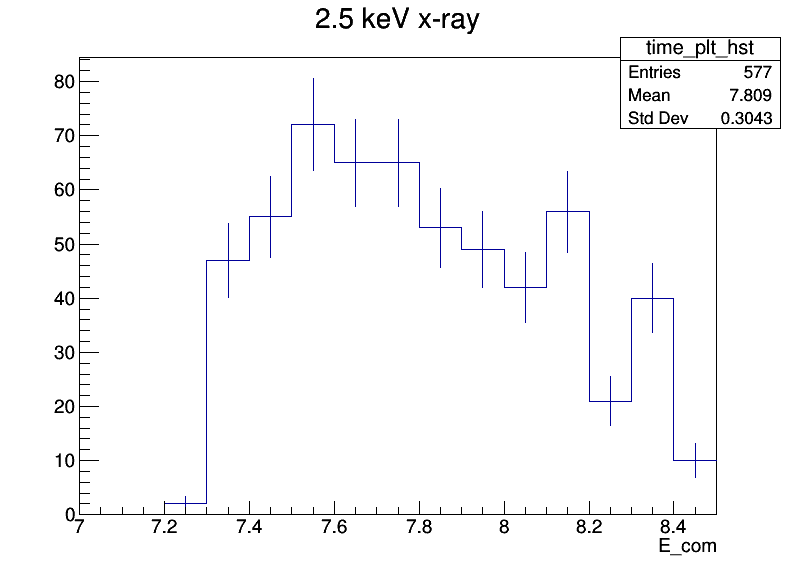

In [135]:
c6 = rootnotes_nersc.default_canvas(name='time_hist_2')

energy_cut=TCut('1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'>2 &&1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'<3.5' )

time_plt_hst=TH1F('time_plt_hst','2.5 keV x-ray;E_com',15,7,8.5)
n=chain.Draw('luxstamp/10**15>>time_plt_hst',combined_cut + energy_cut) # WS is chain2,
time_plt_hst.SetOption("EH")

rtshow(c6)

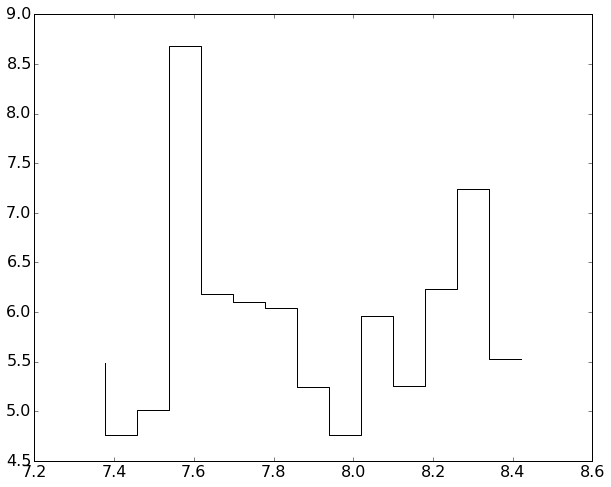

In [142]:
luxstamps = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
luxstamps_hist, xedges = histogram(luxstamps,14) #linspace(7,8.5,10)
bin_center=(xedges[1:]+xedges[:-1])/2

livetime_in_bin=[]
for ii in range(0,luxstamps_hist.size):
    hist_cut=aLib.inrange(Run03Golden_lux_stamps/10**15,(xedges[ii],xedges[ii+1]))
    livetime_in_bin.append(Golden_Livetime_days[hist_cut].sum())

    
livetime_in_bin=array(livetime_in_bin)
plt.plot(xedges[1:],luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')

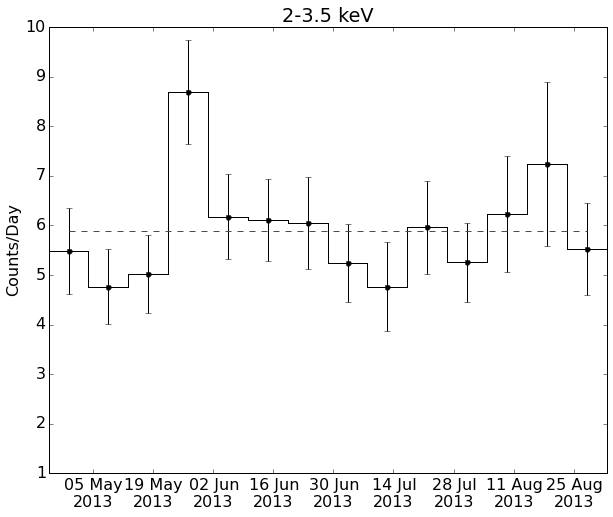

In [145]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=bin_center*10**7/3600/24
luxstamp2day_edge_r=xedges[1:]*10**7/3600/24
luxstamp2day_edge_l=xedges[:-1]*10**7/3600/24

luxdatenum=luxstamp2day+lux_epoch
luxdatenum_edge_l=luxstamp2day_edge_l+lux_epoch
luxdatenum_edge_r=luxstamp2day_edge_r+lux_epoch

####################
fit_start=datestr2num('Apr 20 2013 at 00:00')
fit_end=datestr2num('Sep 1 2013 at 00:00')
fit_offset=1
fit_range=(luxdatenum>fit_start) & (luxdatenum<fit_end)
####################

popt, pcov = curve_fit(funsin, (luxdatenum[fit_range]-luxdatenum[0]), (luxstamps_hist[fit_range]/livetime_in_bin[fit_range])-fit_offset,p0=(20,20,1),maxfev = 100000)

plt.plot_date(luxdatenum_edge_r,luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')
plt.step(luxdatenum_edge_l,luxstamps_hist/livetime_in_bin,'k',where='post')
plt.errorbar(luxdatenum,luxstamps_hist/livetime_in_bin,sqrt(luxstamps_hist)/livetime_in_bin,fmt=".k",markersize=10)
#plt.plot_date([file_dates,file_dates],[zeros(file_dates.size),70*ones(file_dates.size)],'--r')

plt.rcParams.update({'font.size': 16}) #increase all fontsizes
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.ylabel('Counts/Day')

#plot fit
#plt.plot(luxdatenum[fit_range], funsin((luxdatenum[fit_range]-luxdatenum[0]), *popt)+fit_offset, 'r-', label="Fitted Curve")

#plt.text(luxdatenum.max(),luxstamps_hist.max()/livetime_in_bin.max(),'T_1/2={:1.1f} +/- {:1.1f} days'.format(popt[1]*log(2),sqrt(pcov[1,1])*log(2)),
#         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
#plt.ylim([0,luxstamps_hist.max()/livetime_in_bin.max()*1.1])

plt.plot([luxdatenum.min(),luxdatenum.max()],[fit_offset,fit_offset],'--b')

#plot mean
plt.plot([luxdatenum.min(),luxdatenum.max()],[mean(luxstamps_hist/livetime_in_bin),mean(luxstamps_hist/livetime_in_bin)],'--r')

plt.title('2-3.5 keV')



In [141]:
popt

array([  2.09542913,  44.98799526,   3.09497319])

In [181]:
num2date(luxdatenum_edge_r[4])

datetime.datetime(2013, 6, 2, 1, 0, 23, 923604, tzinfo=<matplotlib.dates._UTC object at 0x7f69461fda90>)

<h1> Cut in energy and make a scatter plot in discrimination space </h1>

In [68]:
c22.Clear()

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst_3 (Potential memory leak).


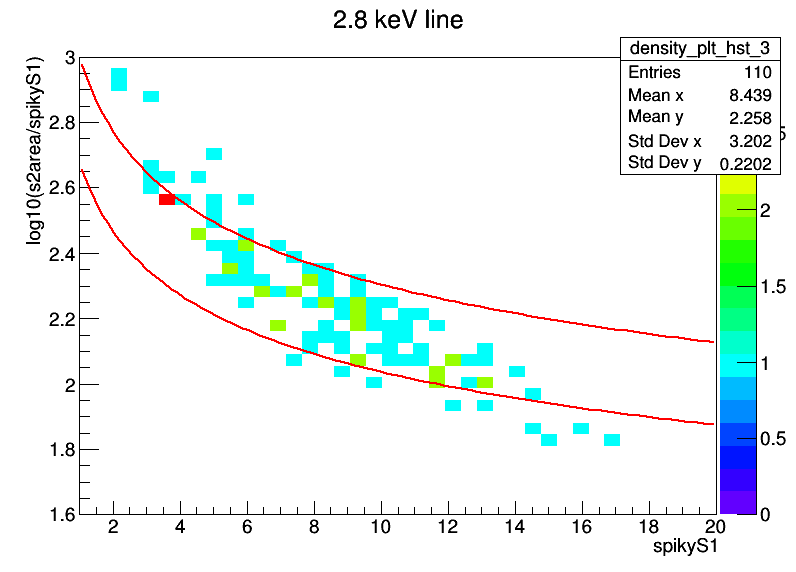

In [70]:
c22 = rootnotes_nersc.default_canvas(name='icanvas_dis', size=(800, 600))
energy_cut=TCut('1/73*(spikyS1/{:g}+s2area/{:g})>{:g} && 1/73*(spikyS1/{:g}+s2area/{:g})<{:g}'
               .format(g1,g2,1.8,g1,g2,3.4))

chain.SetMarkerStyle(7)
chain.SetMarkerSize(10)
density_plt_hst_3=TH2F('density_plt_hst_3','2.8 keV line;spikyS1;log10(s2area/spikyS1)',40,1,20,40,1.6,3)
#density_plt_hst.Draw()
chain.Draw('log10(s2area/spikyS1):spikyS1>>density_plt_hst_3',combined_cut+energy_cut,'colz') #s1area

au = 3.007  #use 3.10 for 2 sigma bounds #90% 3.007
bu = -0.1158  
al = 2.682 # use 2.592  for 2 sigma #90% 2.682
bl =-0.1197

fun1 = TF1( 'fun1', '{:g}*x^{:g}'.format(al,bl), 0, 50)
fun2 = TF1( 'fun1', '{:g}*x^{:g}'.format(au,bu), 0, 50)
fun1.Draw('Same')
fun2.Draw('Same')


rtshow(c22)

<h1> Get luxstamps </h1>

In [162]:
energy_cut=TCut('1/73*(spikyS1/{:g}+s2area/{:g})>{:g} && 1/73*(spikyS1/{:g}+s2area/{:g})<{:g}'
               .format(g1,g2,2,g1,g2,3.5))

#n=chain.Draw('luxstamp',combined_cut+energy_cut+rate_spike_cut) #s1area

total_cut=TCut(combined_cut + energy_cut + rate_spike_cut)

stamps = tree2rec(chain,'luxstamp',selection=total_cut.GetTitle())

In [161]:
luxstamps.size

23

In [167]:
#stamps= ndarray( (n,),dtype= float64, buffer=chain.GetV1())
for ii in range(0,stamps.size):
    print("{:},".format(stamps[ii]))

7554063401986057,
7556356167967821,
7556741985702982,
7560333723988671,
7563858960804691,
7564750648562262,
7573120450943578,
7573644376974124,
7574221305409785,
7578872065742853,
7587596375105307,
7592365653601017,
7593250760203899,
7595135195398816,
7597372267770815,
7597735304663132,
7598883052430767,
7604468469918760,
7607047491426093,
7615442880615203,
7621876702817774,
7628497538088792,
7628999502962024,


In [ ]:
#c3.Clear()

In [25]:
c3 = rootnotes_nersc.default_canvas(name='3keV')

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: density_plt_hst2 (Potential memory leak).


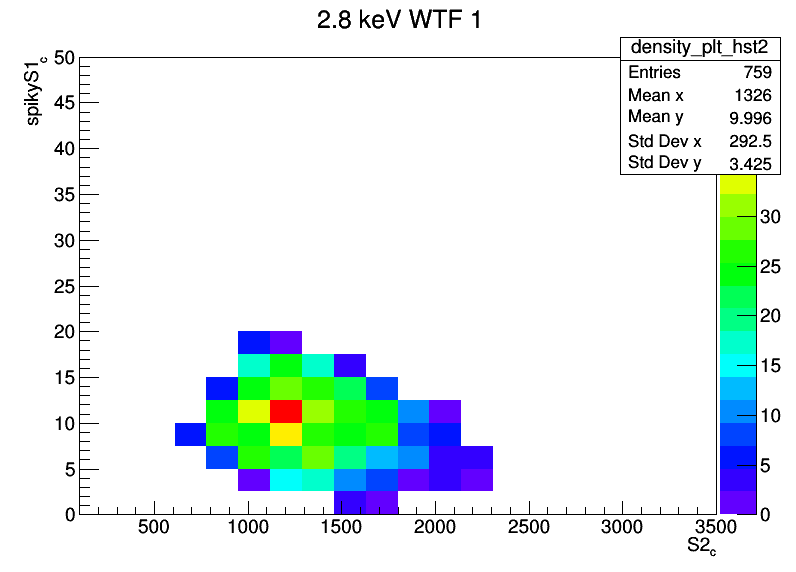

In [22]:
#chain.SetMarkerStyle(7)
#chain.SetMarkerSize(10)
#setup s2 vs s2 hist to get LY,QY
density_plt_hst2=TH2F('density_plt_hst2','2.8 keV WTF 1;S2_{c};spikyS1_{c}',20,100,3500,20,0,50)
energy_cut=TCut('1/73*(spikyS1/{:g}+s2area/{:g})>{:g} && 1/73*(spikyS1/{:g}+s2area/{:g})<{:g}'
               .format(g1,g2,cutsE[0,0],g1,g2,cutsE[0,1]))


n=chain.Draw('spikyS1:s2area>>density_plt_hst2',combined_cut+energy_cut,'colz') #s1area

rtshow(c3)

In [23]:
s1 = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
s2 = ndarray( (n,),dtype= float64, buffer=chain.GetV2())


In [24]:
s1.size

759

In [25]:
H, xedges, yedges = histogram2d(s2, s1, bins=7, range=None, normed=False)
H=H.T
x_bin_center=(xedges[:-1]+xedges[1:])/2
y_bin_center=(yedges[:-1]+yedges[1:])/2

initial_guess = (H.max(), mean(s2), mean(s1), std(s2), std(s1),0,0)
x, y = np.meshgrid(x_bin_center, y_bin_center)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), H.ravel(), p0=initial_guess)

mean_s2[0]=popt[1]
mean_s2_sig[0]=sqrt(pcov[1,1])
mean_s1[0]=popt[2]
mean_s1_sig[0]=sqrt(pcov[2,2])



In [ ]:
savetxt('Run03_Golden_Doke/fits/3keVfit.txt', popt, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')
savetxt('Run03_Golden_Doke/fits/3keVcov.txt', pcov, fmt='%.18e', delimiter=' ', newline='\n', header='', footer='', comments='# ')

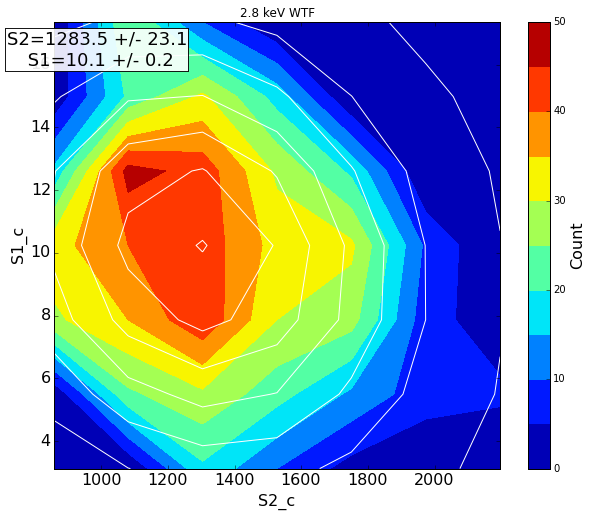

In [26]:
data_fitted = twoD_Gaussian((x, y), *popt)
figure
fig, ax = plt.subplots(1,1)
ax.hold(True)
#ax.imshow(H.reshape(x.shape), cmap=plt.cm.jet, origin='bottom',
#    extent=(x.min(), x.max(), y.min(), y.max()))
plt.contourf(x_bin_center,y_bin_center,H,10)
ax.contour(x, y, data_fitted.reshape(x.shape), 7, colors='w')
plt.xlabel('S2_c',fontsize=16)
plt.ylabel('S1_c',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cb=plt.colorbar()
cb.set_label('Count',fontsize=16)
plt.text(x.min()*1.15,y.max()*.95,'S2={:1.1f} +/- {:1.1f} \n S1={:1.1f} +/- {:1.1f}'.format(popt[1],sqrt(pcov[1,1]),popt[2],sqrt(pcov[2,2])),
         horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('2.8 keV WTF')
#savefig('Run03_Golden_Doke/5keV_fit.pdf')

<h1> Check the R vs Z distribuation of the 2.8 keV events </h1>

In [122]:
c4.Clear()
c4 = rootnotes_nersc.default_canvas(name='Ar_RZ')

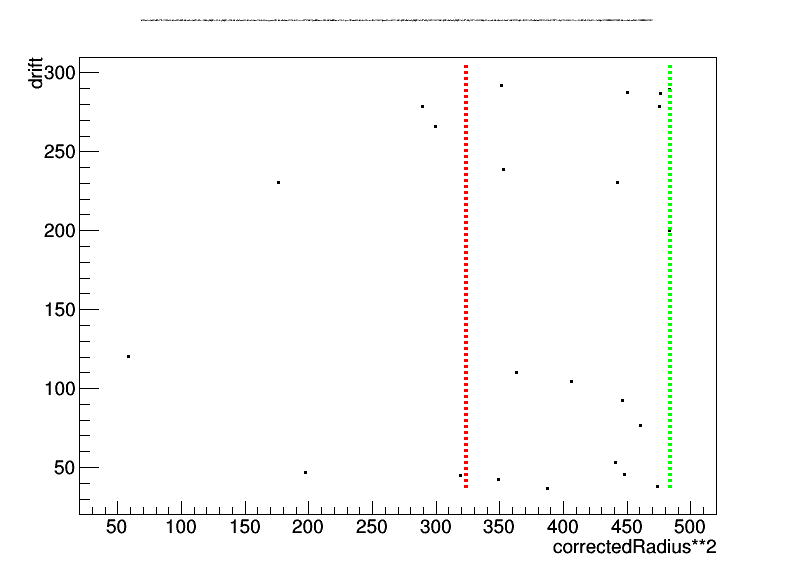

In [123]:
chain.SetMarkerStyle(7)
chain.SetMarkerSize(10)
#density_plt_hst=TH2F('density_plt_hst','5.2 keV x-ray 1;S2_{c};spikyS1_{c}',20,500,3500,20,1,50)
#density_plt_hst.Draw()
chain.Draw('drift:correctedRadius**2',combined_cut+energy_cut+rate_spike_cut) #s1area

linR18=TLine(18**2,35.5,18**2,305)
linR18.SetLineColor(2)
linR18.SetLineStyle(2)
linR18.SetLineWidth(4)
linR18.Draw()

linR21=TLine(22**2,35.5,22**2,305)
linR21.SetLineColor(3)
linR21.SetLineStyle(2)
linR21.SetLineWidth(4)
linR21.Draw()
rtshow(c4)

In [139]:
c5.Clear()
c5 = rootnotes_nersc.default_canvas(name='New_XY')

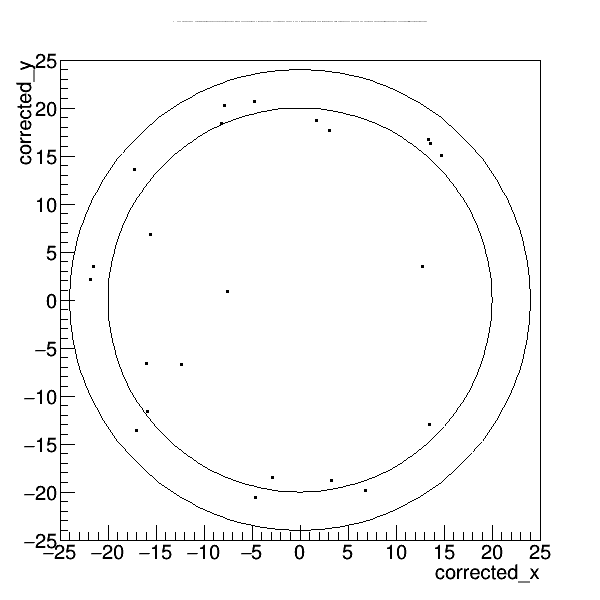

In [155]:
c5.SetCanvasSize(600,600)

chain.SetMarkerStyle(7)
chain.SetMarkerSize(10)
#density_plt_hst=TH2F('density_plt_hst','5.2 keV x-ray 1;S2_{c};spikyS1_{c}',20,500,3500,20,1,50)
#density_plt_hst.Draw()


htemp=chain.Draw('corrected_y:corrected_x',combined_cut+energy_cut+rate_spike_cut) #s1area

htemp = c5.GetPrimitive("htemp")
htemp.GetXaxis().SetLimits(-25,25)
htemp.GetXaxis().SetRangeUser(-25,25)
htemp.GetYaxis().SetLimits(-25,25)
htemp.GetYaxis().SetRangeUser(-25,25)

Circ=TEllipse(0,0,20,20)
Circ.SetFillColor(0)
Circ.SetFillStyle(0)
Circ.Draw()

Circ2=TEllipse(0,0,24,24)
Circ2.SetFillColor(0)
Circ2.SetFillStyle(0)
Circ2.Draw()


rtshow(c5)

<h1> 7 to 8 keV </h1>

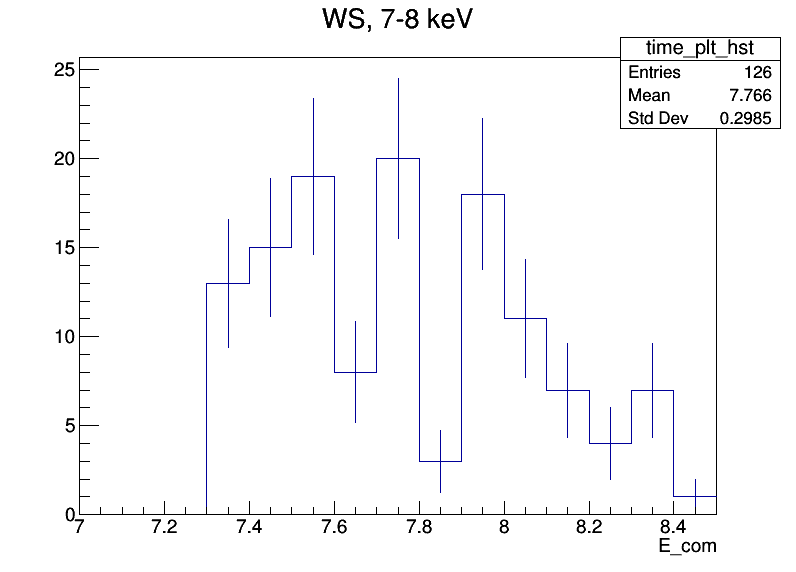

In [18]:
c7 = rootnotes_nersc.default_canvas(name='time_hist_2')

energy_cut=TCut('1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'>7 &&1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'<8' )

time_plt_hst=TH1F('time_plt_hst','WS, 7-8 keV;E_com',15,7,8.5)
n=chain.Draw('luxstamp/10**15>>time_plt_hst',combined_cut + energy_cut) # WS is chain2,
time_plt_hst.SetOption("EH")

rtshow(c7)

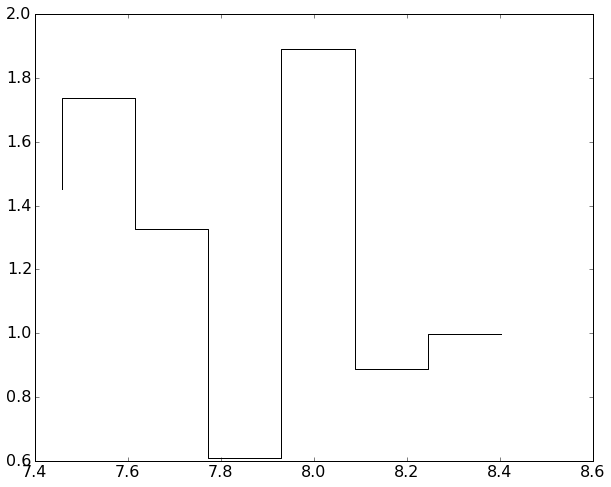

In [24]:
luxstamps = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
luxstamps_hist, xedges = histogram(luxstamps,7) #linspace(7,8.5,10)
bin_center=(xedges[1:]+xedges[:-1])/2

livetime_in_bin=[]
for ii in range(0,luxstamps_hist.size):
    hist_cut=aLib.inrange(Run03Golden_lux_stamps/10**15,(xedges[ii],xedges[ii+1]))
    livetime_in_bin.append(Golden_Livetime_days[hist_cut].sum())

    
livetime_in_bin=array(livetime_in_bin)
plt.plot(xedges[1:],luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')

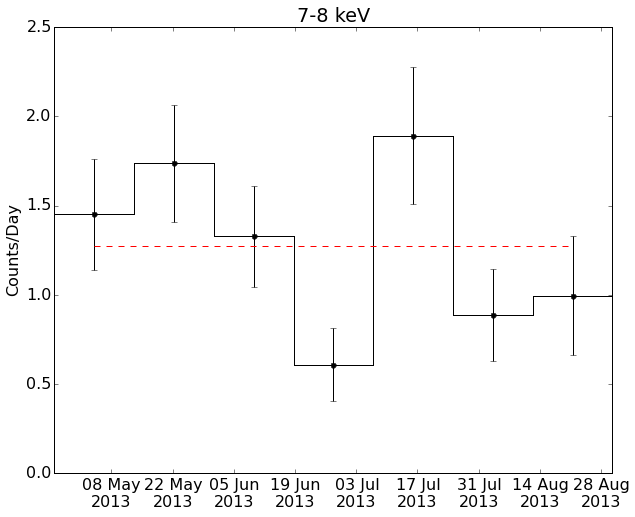

In [25]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=bin_center*10**7/3600/24
luxstamp2day_edge_r=xedges[1:]*10**7/3600/24
luxstamp2day_edge_l=xedges[:-1]*10**7/3600/24

luxdatenum=luxstamp2day+lux_epoch
luxdatenum_edge_l=luxstamp2day_edge_l+lux_epoch
luxdatenum_edge_r=luxstamp2day_edge_r+lux_epoch
'''
####################
fit_start=datestr2num('Apr 20 2013 at 00:00')
fit_end=datestr2num('Sep 1 2013 at 00:00')
fit_offset=1
fit_range=(luxdatenum>fit_start) & (luxdatenum<fit_end)
####################

popt, pcov = curve_fit(funsin, (luxdatenum[fit_range]-luxdatenum[0]), (luxstamps_hist[fit_range]/livetime_in_bin[fit_range])-fit_offset,p0=(20,20,1),maxfev = 100000)
'''
plt.plot_date(luxdatenum_edge_r,luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')
plt.step(luxdatenum_edge_l,luxstamps_hist/livetime_in_bin,'k',where='post')
plt.errorbar(luxdatenum,luxstamps_hist/livetime_in_bin,sqrt(luxstamps_hist)/livetime_in_bin,fmt=".k",markersize=10)
#plt.plot_date([file_dates,file_dates],[zeros(file_dates.size),70*ones(file_dates.size)],'--r')

plt.rcParams.update({'font.size': 16}) #increase all fontsizes
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.ylabel('Counts/Day')

#plot fit
#plt.plot(luxdatenum[fit_range], funsin((luxdatenum[fit_range]-luxdatenum[0]), *popt)+fit_offset, 'r-', label="Fitted Curve")

#plt.text(luxdatenum.max(),luxstamps_hist.max()/livetime_in_bin.max(),'T_1/2={:1.1f} +/- {:1.1f} days'.format(popt[1]*log(2),sqrt(pcov[1,1])*log(2)),
#         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
#plt.ylim([0,luxstamps_hist.max()/livetime_in_bin.max()*1.1])
#plt.plot([luxdatenum.min(),luxdatenum.max()],[fit_offset,fit_offset],'--b')

#plot mean
plt.plot([luxdatenum.min(),luxdatenum.max()],[mean(luxstamps_hist/livetime_in_bin),mean(luxstamps_hist/livetime_in_bin)],'--r')

plt.title('7-8 keV')

<h1> 8 to 9 keV </h1>

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: time_plt_hst (Potential memory leak).


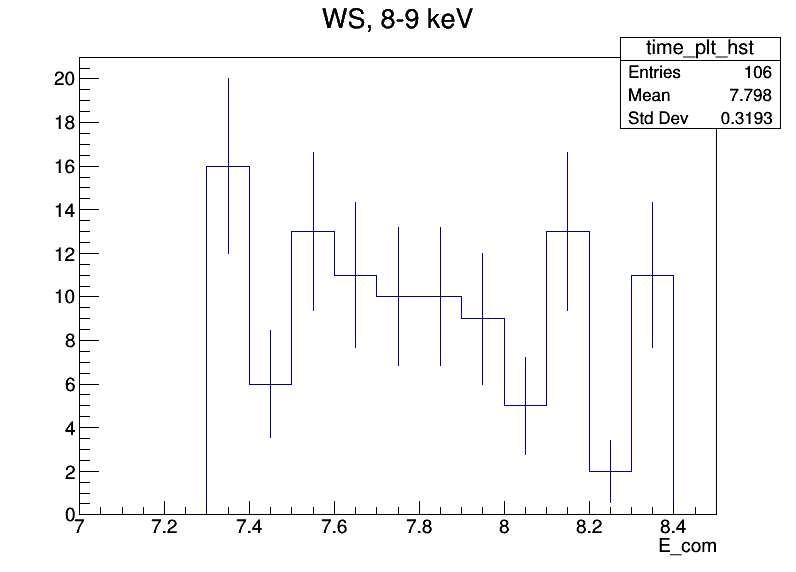

In [26]:
c8 = rootnotes_nersc.default_canvas(name='time_hist_2')

energy_cut=TCut('1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'>8 &&1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'<9' )

time_plt_hst=TH1F('time_plt_hst','WS, 8-9 keV;E_com',15,7,8.5)
n=chain.Draw('luxstamp/10**15>>time_plt_hst',combined_cut + energy_cut) # WS is chain2,
time_plt_hst.SetOption("EH")

rtshow(c8)

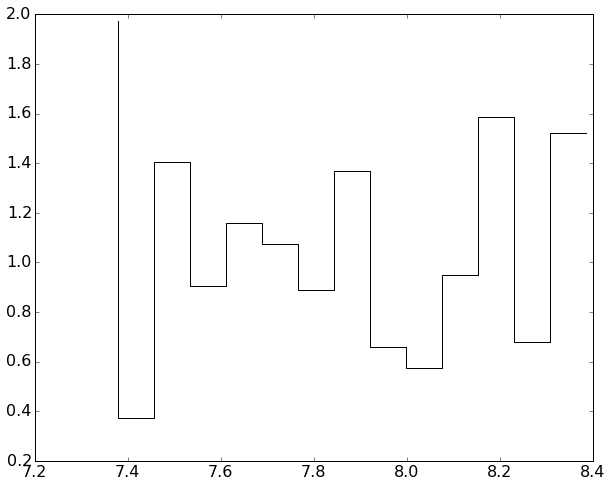

In [31]:
luxstamps = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
luxstamps_hist, xedges = histogram(luxstamps,14) #linspace(7,8.5,10)
bin_center=(xedges[1:]+xedges[:-1])/2

livetime_in_bin=[]
for ii in range(0,luxstamps_hist.size):
    hist_cut=aLib.inrange(Run03Golden_lux_stamps/10**15,(xedges[ii],xedges[ii+1]))
    livetime_in_bin.append(Golden_Livetime_days[hist_cut].sum())

    
livetime_in_bin=array(livetime_in_bin)
plt.plot(xedges[1:],luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')

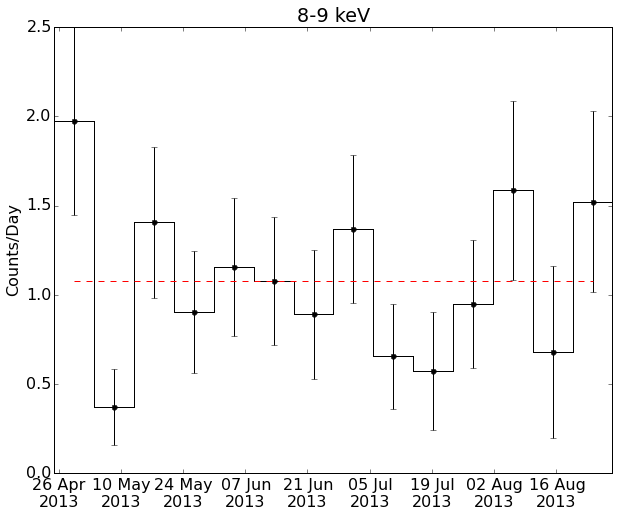

In [32]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=bin_center*10**7/3600/24
luxstamp2day_edge_r=xedges[1:]*10**7/3600/24
luxstamp2day_edge_l=xedges[:-1]*10**7/3600/24

luxdatenum=luxstamp2day+lux_epoch
luxdatenum_edge_l=luxstamp2day_edge_l+lux_epoch
luxdatenum_edge_r=luxstamp2day_edge_r+lux_epoch
'''
####################
fit_start=datestr2num('Apr 20 2013 at 00:00')
fit_end=datestr2num('Sep 1 2013 at 00:00')
fit_offset=1
fit_range=(luxdatenum>fit_start) & (luxdatenum<fit_end)
####################

popt, pcov = curve_fit(funsin, (luxdatenum[fit_range]-luxdatenum[0]), (luxstamps_hist[fit_range]/livetime_in_bin[fit_range])-fit_offset,p0=(20,20,1),maxfev = 100000)
'''

#### Run03 Circ Stop Dates ### 
circ_stop_1=md.datestr2num('April-25-2013')
circ_stop_2=md.datestr2num('June-24-2013')
circ_stop_3=md.datestr2num('July-01-2013')
circ_stop_4=md.datestr2num('July-20-2013')
circ_stop_5=md.datestr2num('July-31-2013')
circ_stop_6=md.datestr2num('Aug-20-2013')

tritium_1=md.datestr2num('Aug-8-2013')
tritium_2=md.datestr2num('Aug-11-2013')

circ_stop_dates=array([circ_stop_1,circ_stop_2,circ_stop_3,circ_stop_4,circ_stop_5,circ_stop_6])
tritium_dates=array([tritium_1,tritium_2])
#####

#Plot circ stop and tritium injection
#plt.plot_date([circ_stop_dates,circ_stop_dates],[0.4*ones(circ_stop_dates.size),1.8*ones(circ_stop_dates.size)],'--r')
#plt.plot_date([tritium_dates,tritium_dates],[0.4*ones(tritium_dates.size),1.8*ones(tritium_dates.size)],'--b')



plt.plot_date(luxdatenum_edge_r,luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')
plt.step(luxdatenum_edge_l,luxstamps_hist/livetime_in_bin,'k',where='post')
plt.errorbar(luxdatenum,luxstamps_hist/livetime_in_bin,sqrt(luxstamps_hist)/livetime_in_bin,fmt=".k",markersize=10)
#plt.plot_date([file_dates,file_dates],[zeros(file_dates.size),70*ones(file_dates.size)],'--r')

plt.rcParams.update({'font.size': 16}) #increase all fontsizes
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.ylabel('Counts/Day')

#plot fit
#plt.plot(luxdatenum[fit_range], funsin((luxdatenum[fit_range]-luxdatenum[0]), *popt)+fit_offset, 'r-', label="Fitted Curve")

#plt.text(luxdatenum.max(),luxstamps_hist.max()/livetime_in_bin.max(),'T_1/2={:1.1f} +/- {:1.1f} days'.format(popt[1]*log(2),sqrt(pcov[1,1])*log(2)),
#         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
#plt.ylim([0,luxstamps_hist.max()/livetime_in_bin.max()*1.1])
#plt.plot([luxdatenum.min(),luxdatenum.max()],[fit_offset,fit_offset],'--b')

#plot mean
plt.plot([luxdatenum.min(),luxdatenum.max()],[mean(luxstamps_hist/livetime_in_bin),mean(luxstamps_hist/livetime_in_bin)],'--r')

plt.title('8-9 keV')

<h1> 9 to 10 keV </h1>

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: time_plt_hst (Potential memory leak).


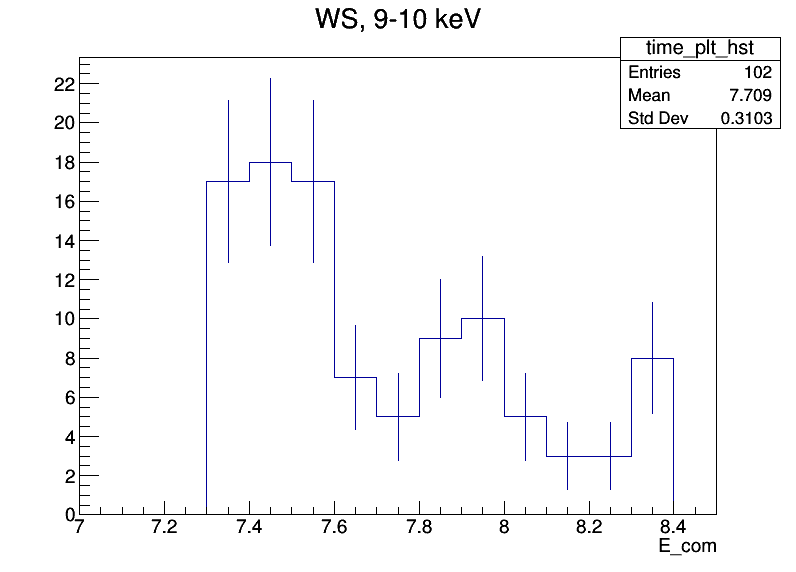

In [33]:
c9 = rootnotes_nersc.default_canvas(name='time_hist_2')

energy_cut=TCut('1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'>9 &&1/73*(s1area/{:g}+s2area/{:g})'.format(g1,g2)+'<10' )

time_plt_hst=TH1F('time_plt_hst','WS, 9-10 keV;E_com',15,7,8.5)
n=chain.Draw('luxstamp/10**15>>time_plt_hst',combined_cut + energy_cut) # WS is chain2,
time_plt_hst.SetOption("EH")

rtshow(c9)

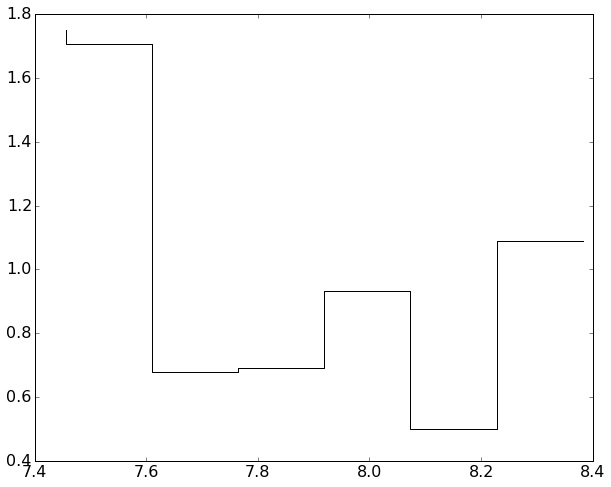

In [37]:
luxstamps = ndarray( (n,),dtype= float64, buffer=chain.GetV1())
luxstamps_hist, xedges = histogram(luxstamps,7) #linspace(7,8.5,10)
bin_center=(xedges[1:]+xedges[:-1])/2

livetime_in_bin=[]
for ii in range(0,luxstamps_hist.size):
    hist_cut=aLib.inrange(Run03Golden_lux_stamps/10**15,(xedges[ii],xedges[ii+1]))
    livetime_in_bin.append(Golden_Livetime_days[hist_cut].sum())

    
livetime_in_bin=array(livetime_in_bin)
plt.plot(xedges[1:],luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')

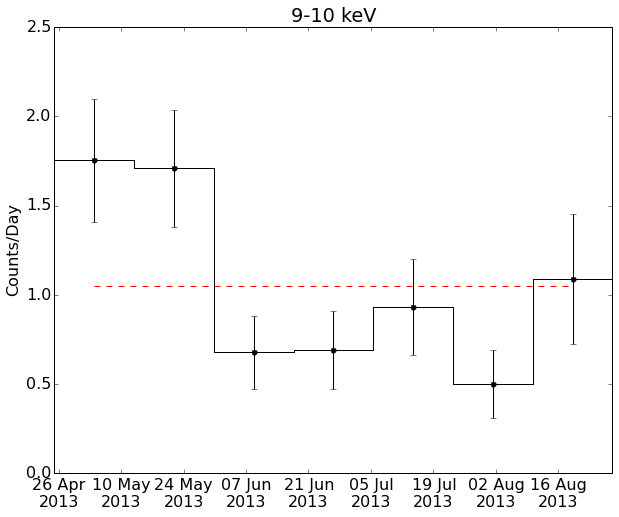

In [38]:
# convert luxstamp to date_num
lux_epoch=datestr2num('Jan 1st 2011 at 00:00')

luxstamp2day=bin_center*10**7/3600/24
luxstamp2day_edge_r=xedges[1:]*10**7/3600/24
luxstamp2day_edge_l=xedges[:-1]*10**7/3600/24

luxdatenum=luxstamp2day+lux_epoch
luxdatenum_edge_l=luxstamp2day_edge_l+lux_epoch
luxdatenum_edge_r=luxstamp2day_edge_r+lux_epoch
'''
####################
fit_start=datestr2num('Apr 20 2013 at 00:00')
fit_end=datestr2num('Sep 1 2013 at 00:00')
fit_offset=1
fit_range=(luxdatenum>fit_start) & (luxdatenum<fit_end)
####################

popt, pcov = curve_fit(funsin, (luxdatenum[fit_range]-luxdatenum[0]), (luxstamps_hist[fit_range]/livetime_in_bin[fit_range])-fit_offset,p0=(20,20,1),maxfev = 100000)
'''

#### Run03 Circ Stop Dates ### 
circ_stop_1=md.datestr2num('April-25-2013')
circ_stop_2=md.datestr2num('June-24-2013')
circ_stop_3=md.datestr2num('July-01-2013')
circ_stop_4=md.datestr2num('July-20-2013')
circ_stop_5=md.datestr2num('July-31-2013')
circ_stop_6=md.datestr2num('Aug-20-2013')

tritium_1=md.datestr2num('Aug-8-2013')
tritium_2=md.datestr2num('Aug-11-2013')

circ_stop_dates=array([circ_stop_1,circ_stop_2,circ_stop_3,circ_stop_4,circ_stop_5,circ_stop_6])
tritium_dates=array([tritium_1,tritium_2])
#####

#Plot circ stop and tritium injection
#plt.plot_date([circ_stop_dates,circ_stop_dates],[0.4*ones(circ_stop_dates.size),1.8*ones(circ_stop_dates.size)],'--r')
#plt.plot_date([tritium_dates,tritium_dates],[0.4*ones(tritium_dates.size),1.8*ones(tritium_dates.size)],'--b')



plt.plot_date(luxdatenum_edge_r,luxstamps_hist/livetime_in_bin,'k',drawstyle='steps')
plt.step(luxdatenum_edge_l,luxstamps_hist/livetime_in_bin,'k',where='post')
plt.errorbar(luxdatenum,luxstamps_hist/livetime_in_bin,sqrt(luxstamps_hist)/livetime_in_bin,fmt=".k",markersize=10)
#plt.plot_date([file_dates,file_dates],[zeros(file_dates.size),70*ones(file_dates.size)],'--r')

plt.rcParams.update({'font.size': 16}) #increase all fontsizes
ax = gca()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d %b\n%Y'))
plt.ylabel('Counts/Day')

#plot fit
#plt.plot(luxdatenum[fit_range], funsin((luxdatenum[fit_range]-luxdatenum[0]), *popt)+fit_offset, 'r-', label="Fitted Curve")

#plt.text(luxdatenum.max(),luxstamps_hist.max()/livetime_in_bin.max(),'T_1/2={:1.1f} +/- {:1.1f} days'.format(popt[1]*log(2),sqrt(pcov[1,1])*log(2)),
#         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
#plt.ylim([0,luxstamps_hist.max()/livetime_in_bin.max()*1.1])
#plt.plot([luxdatenum.min(),luxdatenum.max()],[fit_offset,fit_offset],'--b')

#plot mean
plt.plot([luxdatenum.min(),luxdatenum.max()],[mean(luxstamps_hist/livetime_in_bin),mean(luxstamps_hist/livetime_in_bin)],'--r')

plt.title('9-10 keV')

In [ ]:
clearCanvas()